In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [15]:
train_data = pd.read_csv("/content/drive/MyDrive/data/restaurant-revenue-prediction.zip (Unzipped Files)/train.csv.zip")
test_data = pd.read_csv("/content/drive/MyDrive/data/restaurant-revenue-prediction.zip (Unzipped Files)/test.csv.zip")

In [16]:
label_encoder = preprocessing.LabelEncoder()
l = [i for i in train_data.columns if train_data[i].dtype=='object']
la = [i for i in test_data.columns if test_data[i].dtype=='object']
for i in l:
  train_data[i]= label_encoder.fit_transform(train_data[i])
for i in la:
  test_data[i]= label_encoder.fit_transform(test_data[i])

In [17]:
train_data.describe()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,65.248175,20.627737,0.430657,1.430657,4.014599,4.408759,4.317518,4.372263,2.007299,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,39.315425,11.819729,0.496985,0.511567,2.910391,1.514900,1.032337,1.016462,1.209620,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,31.000000,8.000000,0.000000,1.000000,2.000000,4.000000,4.000000,4.000000,1.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,65.000000,26.000000,0.000000,1.000000,3.000000,5.000000,4.000000,4.000000,2.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,99.000000,31.000000,1.000000,2.000000,4.000000,5.000000,5.000000,5.000000,2.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,133.000000,33.000000,1.000000,2.000000,12.000000,7.500000,7.500000,7.500000,8.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


In [18]:
correlation_matrix = train_data.corr().abs()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
correlation_pairs = (correlation_matrix.mask(mask) >= 0.9).stack()
features_to_drop = set([pair[1] for pair in correlation_pairs[correlation_pairs].index])
train_data.drop(columns=features_to_drop, inplace=True)
train_data = train_data.drop(columns=['Open Date'])
train_data.columns.to_series().to_csv('column_names.csv', index=False, header=True)

In [19]:
X = train_data.drop(columns=['revenue'], axis=1)
Y = train_data["revenue"]
x = train_data.iloc[:,:-1]
y = train_data.iloc[:,-1]

<Axes: >

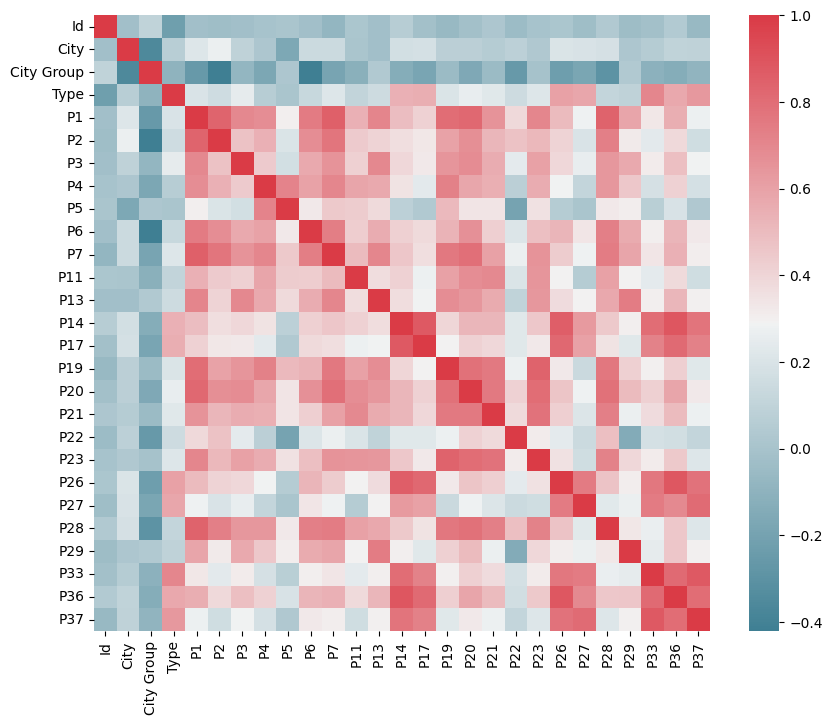

In [20]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool_),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [21]:
x_train, X_valid, y_train, Y_valid = train_test_split(x, y, test_size=0.2, random_state=10)

Мною был выбран XGBoost, так как он использует более сложные методы обучения, такие как градиентный бустинг, что позволяет ему находить оптимальные веса для каждого дерева в ансамбле. Это может привести к более точным прогнозам.

In [22]:
params_xgb = {
    'learning_rate': [.1, .5, .7, .9, .95, .99, 1],
    'colsample_bytree': [.3, .4, .5, .6],
    'max_depth': [4],
    'alpha': [3],
    'subsample': [.5],
    'n_estimators': [30, 70, 100, 200]
}

xgb_model = XGBRegressor()
xgb_regressor = RandomizedSearchCV(xgb_model, params_xgb, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
xgb_regressor.fit(x_train, y_train)
print(f'Optimal lr: {xgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal colsample_bytree: {xgb_regressor.best_params_["colsample_bytree"]}')
print(f'Optimal n_estimators: {xgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {xgb_regressor.best_score_}')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Optimal lr: 0.1
Optimal colsample_bytree: 0.6
Optimal n_estimators: 30
Best score: -2108465.6301474506


In [23]:
xgb_model = XGBRegressor(learning_rate=xgb_regressor.best_params_["learning_rate"],
                         colsample_bytree=xgb_regressor.best_params_["colsample_bytree"],
                         max_depth=4, alpha=3, subsample=.5,
                         n_estimators=xgb_regressor.best_params_["n_estimators"], n_jobs=-1)
xgb_model.fit(x_train, y_train)
y_train_pred = xgb_model.predict(x_train)
y_pred = xgb_model.predict(X_valid)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(Y_valid, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(Y_valid, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.27634542569386145
Test r2 score:  0.07077903626391835
Train RMSE: 1219465.2257
Test RMSE: 2852725.0283


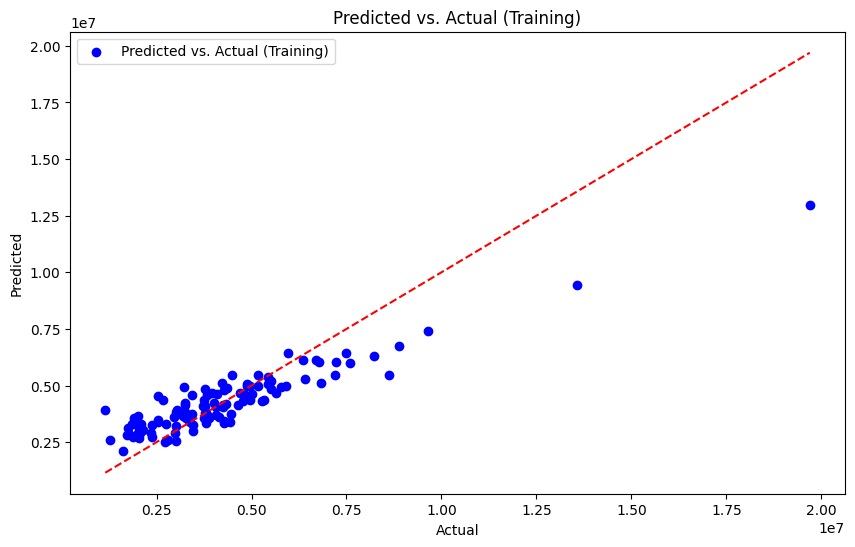

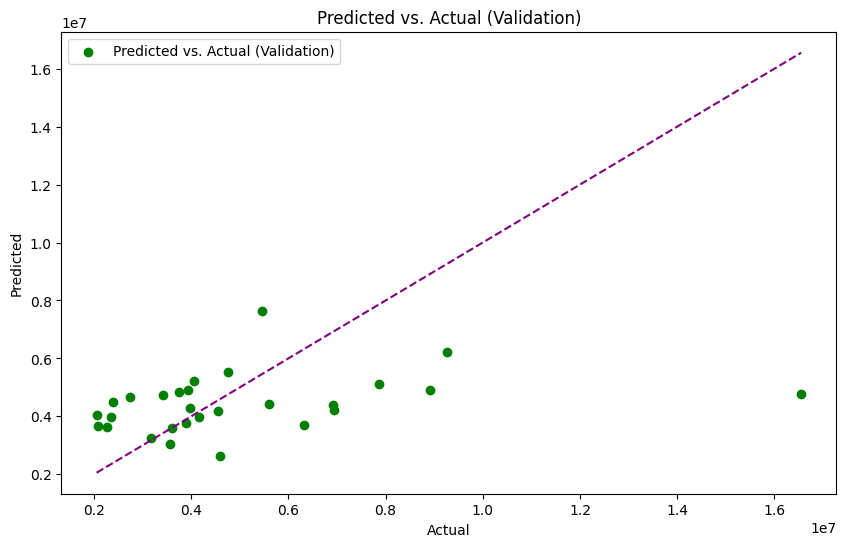

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Predicted vs. Actual (Training)')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual (Training)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(Y_valid, y_pred, color='green', label='Predicted vs. Actual (Validation)')
plt.plot([min(Y_valid), max(Y_valid)], [min(Y_valid), max(Y_valid)], color='purple', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual (Validation)')
plt.legend()
plt.show()


In [44]:
filename = 'model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

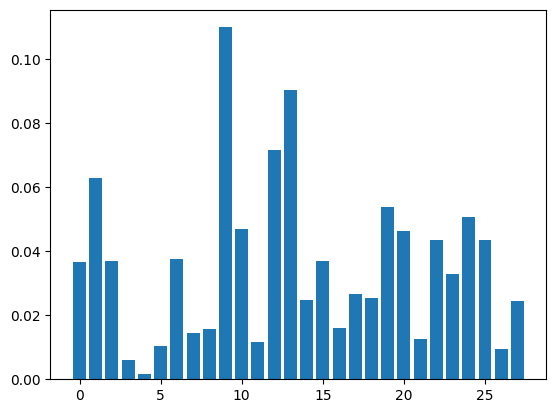

In [24]:
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.show()

In [25]:
model=Sequential()
model.add(Dense(units=20,input_dim=28,activation="tanh"))
model.add(Dense(units=20,activation="relu"))
model.add(Dense(units=20,activation="relu"))
model.add(Dense(1))

In [26]:
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['RootMeanSquaredError'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                290       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 521 (2.04 KB)
Trainable params: 521 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Как можно видеть, количество настраиваемых парамаетров в простейшей нейронной сети равно 521. Тестовых данных меньше , чем настраиваемых параметров, значит обучить такую нейронную сеть не представляется возможным.**

In [ ]:
model.fit(x_train, y_train, epochs=50, validation_data=(X_valid, Y_valid))

Epoch 1/50
4/4 [==============================] - 1s 71ms/step - loss: 24617141927936.0000 - root_mean_squared_error: 4961566.5000 - val_loss: 33446372048896.0000 - val_root_mean_squared_error: 5783284.0000
Epoch 2/50
4/4 [==============================] - 0s 13ms/step - loss: 24617139830784.0000 - root_mean_squared_error: 4961566.5000 - val_loss: 33446367854592.0000 - val_root_mean_squared_error: 5783283.5000
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 24617139830784.0000 - root_mean_squared_error: 4961566.5000 - val_loss: 33446365757440.0000 - val_root_mean_squared_error: 5783283.5000
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 24617131442176.0000 - root_mean_squared_error: 4961565.5000 - val_loss: 33446363660288.0000 - val_root_mean_squared_error: 5783283.0000
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: 24617129345024.0000 - root_mean_squared_error: 4961565.0000 - val_loss: 33446359465984.0000 - val_roo

In [ ]:
mse, rmse = model.evaluate(X_valid, Y_valid)
print(rmse)
print(mse)

1/1 [==============================] - 0s 32ms/step - loss: 33443601711104.0000 - root_mean_squared_error: 5783044.5000
5783044.5
33443601711104.0


**Для улучшения качества можно попробовать использовать автоенкодерную нейронную сеть для более эффективного feauture selection.**
